In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# Device will determine whether to run the training on GPU or CPU.
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
# Define hyperparameters
batch_size = 16
num_classes = 10
learning_rate = 0.001
num_epochs = 20

In [4]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [5]:
# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [6]:
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [7]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [8]:
# define the CNN architecture
class CNN(nn.Module):
   

    def __init__(self):
        
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x = self.conv_layer(x)
        
        # flatten
        x = x.view(x.size(0), -1)
        
        # fc layer
        x = self.fc_layer(x)

        return x

In [9]:
# create a complete CNN
model = CNN()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout2d(p=0.05, inplace=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [10]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [11]:
# number of epochs to train the model
n_epochs = [*range(num_epochs)]

for epoch in n_epochs:

    # keep track of training and validation loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

  
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)

        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, train_loss))

Epoch: 0 	Training Loss: 2.046116
Epoch: 1 	Training Loss: 1.560876
Epoch: 2 	Training Loss: 1.336012
Epoch: 3 	Training Loss: 1.147281
Epoch: 4 	Training Loss: 1.002785
Epoch: 5 	Training Loss: 0.892369
Epoch: 6 	Training Loss: 0.808235
Epoch: 7 	Training Loss: 0.734332
Epoch: 8 	Training Loss: 0.670775
Epoch: 9 	Training Loss: 0.614169
Epoch: 10 	Training Loss: 0.560279
Epoch: 11 	Training Loss: 0.510436
Epoch: 12 	Training Loss: 0.462189
Epoch: 13 	Training Loss: 0.417201
Epoch: 14 	Training Loss: 0.377693
Epoch: 15 	Training Loss: 0.335139
Epoch: 16 	Training Loss: 0.299196
Epoch: 17 	Training Loss: 0.268230
Epoch: 18 	Training Loss: 0.236513
Epoch: 19 	Training Loss: 0.210602


In [12]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.761564

Test Accuracy of airplane: 78% (786/1000)
Test Accuracy of automobile: 87% (876/1000)
Test Accuracy of  bird: 68% (689/1000)
Test Accuracy of   cat: 66% (669/1000)
Test Accuracy of  deer: 78% (781/1000)
Test Accuracy of   dog: 62% (621/1000)
Test Accuracy of  frog: 84% (842/1000)
Test Accuracy of horse: 82% (828/1000)
Test Accuracy of  ship: 86% (861/1000)
Test Accuracy of truck: 83% (831/1000)

Test Accuracy (Overall): 77% (7784/10000)


# Question 1

In [13]:
class CNN1(nn.Module):
 
    def __init__(self):

        super(CNN1, self).__init__()       
        
        self.conv_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.Dropout2d(p=0.1),
            
            # Conv Layer block 2
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
             nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.1),)

        
        self.fc_layer = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.05),
            nn.Linear(64, 10))
        

In [14]:
class CNN2(nn.Module):
 
    def __init__(self):
 
        super(CNN1, self).__init__()
        self.conv_layer = nn.Sequential(
            
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.Dropout2d(p=0.05),
            )

        self.fc_layer = nn.Sequential(
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
            )

In [15]:
class CNN3(nn.Module):
 
    def __init__(self):
 
        super(CNN1, self).__init__()
        self.conv_layer = nn.Sequential(
            
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            )

        self.fc_layer = nn.Sequential(
            nn.Linear(1024, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(32, 10)
            )


# Question 2

In [16]:
model = CNN()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout2d(p=0.05, inplace=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [17]:
# number of epochs to train the model
n_epochs = [*range(num_epochs)]
for epoch in n_epochs:
 # keep track of training and validation loss
    train_loss = 0.0
 ###################
 # train the model #
 ###################
    model.train()
    for data, target in train_loader:
 # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
 # clear the gradients of all optimized variables
        optimizer.zero_grad()
 # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
 # calculate the batch loss
        loss = criterion(output, target)
# backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
        # calculate average losses
        train_loss = train_loss/len(train_loader.dataset)
        
        # print training/validation statistics
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))


Streaming output truncated to the last 5000 lines.
Epoch: 18 	Training Loss: 0.000053
Epoch: 18 	Training Loss: 0.000040
Epoch: 18 	Training Loss: 0.000055
Epoch: 18 	Training Loss: 0.000056
Epoch: 18 	Training Loss: 0.000131
Epoch: 18 	Training Loss: 0.000084
Epoch: 18 	Training Loss: 0.000018
Epoch: 18 	Training Loss: 0.000072
Epoch: 18 	Training Loss: 0.000103
Epoch: 18 	Training Loss: 0.000035
Epoch: 18 	Training Loss: 0.000037
Epoch: 18 	Training Loss: 0.000050
Epoch: 18 	Training Loss: 0.000092
Epoch: 18 	Training Loss: 0.000057
Epoch: 18 	Training Loss: 0.000065
Epoch: 18 	Training Loss: 0.000031
Epoch: 18 	Training Loss: 0.000089
Epoch: 18 	Training Loss: 0.000107
Epoch: 18 	Training Loss: 0.000061
Epoch: 18 	Training Loss: 0.000054
Epoch: 18 	Training Loss: 0.000097
Epoch: 18 	Training Loss: 0.000037
Epoch: 18 	Training Loss: 0.000049
Epoch: 18 	Training Loss: 0.000062
Epoch: 18 	Training Loss: 0.000047
Epoch: 18 	Training Loss: 0.000099
Epoch: 18 	Training Loss: 0.000185
Epoc

In [18]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval()
# iterate over test data
for data, target in test_loader:
 # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1) 
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (classes[i], 100 * class_correct[i] / class_total[i],np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total),np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.828774

Test Accuracy of airplane: 81% (818/1000)
Test Accuracy of automobile: 86% (869/1000)
Test Accuracy of  bird: 69% (697/1000)
Test Accuracy of   cat: 64% (641/1000)
Test Accuracy of  deer: 72% (727/1000)
Test Accuracy of   dog: 72% (720/1000)
Test Accuracy of  frog: 66% (661/1000)
Test Accuracy of horse: 86% (866/1000)
Test Accuracy of  ship: 81% (811/1000)
Test Accuracy of truck: 80% (803/1000)

Test Accuracy (Overall): 76% (7613/10000)


# Question 3

In [19]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])

In [20]:
train_path = './CIFAR10/train/'
test_path = './CIFAR10/test/'
trainset = datasets.CIFAR10(train_path, download=True, train=True, transform=transform)
valset = datasets.CIFAR10(test_path, download=True, train=False, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./CIFAR10/train/cifar-10-python.tar.gz to ./CIFAR10/train/


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./CIFAR10/test/cifar-10-python.tar.gz to ./CIFAR10/test/


In [21]:
for option in dir(trainset):
    if option[0] != '_':
        print(option)

base_folder
class_to_idx
classes
data
download
extra_repr
filename
meta
root
target_transform
targets
test_list
tgz_md5
train
train_list
transform
transforms
url


In [22]:
print(trainset.data.shape)
print(np.array(trainset.targets).shape)
print(valset.data.shape)
print(np.array(valset.targets).shape)

(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


In [23]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [24]:
for option in dir(trainloader):
    if option[0] != '_':
        print(option)

batch_sampler
batch_size
check_worker_number_rationality
collate_fn
dataset
drop_last
generator
multiprocessing_context
num_workers
persistent_workers
pin_memory
pin_memory_device
prefetch_factor
sampler
timeout
worker_init_fn


In [25]:
import matplotlib.pyplot as plt

In [26]:
dataiter = iter(trainloader)
images ,labels = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])


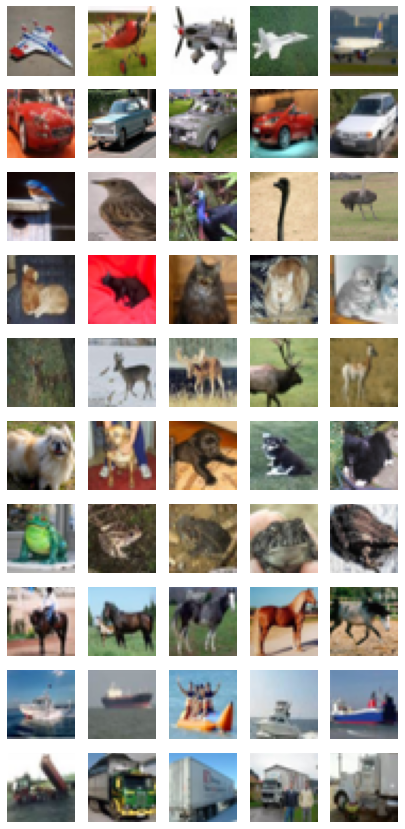

In [27]:

classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_of_images = 5
item = 1
plt.figure(figsize=(7, 15)) 
for i in range(0,10):
  idx = np.where(np.array(trainset.targets) == i)
  PlotImg = np.array(trainset.data)[idx]
  for index in range(1, num_of_images+1):
    plt.subplot(10,5, item)
    plt.axis('off')
    plt.imshow(PlotImg[index].squeeze(),aspect='auto')
    item += 1

In [28]:
import torchvision.models
model = torchvision.models.resnet34(pretrained=True)
model

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [30]:
#Freeza the model

In [31]:
for param in model.parameters():
    param.requires_grad = False

In [32]:
# replace the output layer with your own output layer
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


model.fc = nn.Sequential(
               nn.Linear(512, 1024),
               nn.ReLU(inplace=True),
               nn.Linear(1024, 10)).to(device)

In [33]:
_ = model.to(device)

In [34]:
n_epochs = 20
val_per_epoch = 5
optimizer = optim.Adam(model.fc.parameters())
criterion = nn.CrossEntropyLoss()

In [35]:
def accuracy(y_pred, y):
    """
    Calculating the accuracy of given batch.
    input(s):
    y_pred (ndarray): predicted logits or the output of the model.
    y (ndarray): labels
    """
    pred_idx = y_pred.max(1, keepdim=True)[1]
    correct = pred_idx.eq(y.view_as(pred_idx)).sum().item()
    return correct / len(y)

In [36]:
history = dict()
history['train_loss']= list()
history['train_acc']= list()
history['val_loss']= list()
history['def accuracy(y_pred, y)'] = list()
  
    pred_idx = y_pred.max(1, keepdim=True)[1]
    correct = pred_idx.eq(y.view_as(pred_idx)).sum().item()
    return correct / len(y)val_acc']= list()
for epoch in range(n_epochs):
    running_loss = 0
    running_acc = 0

    model.train()
    for idx, (X, y) in enumerate(tqdm(trainloader)):
        optimizer.zero_grad()
        X, y = X.to(device), y.to(device)
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_acc += accuracy(y_hat, y)
    else:
        running_loss = running_loss/ len(trainloader)
        running_acc = running_acc / len(trainloader)
        history['train_loss'].append(running_loss)
        history['train_acc'].append(running_acc)
        print(f'Epoch {epoch+1}/{n_epochs} : training loss: {running_loss}, training acc: {running_acc}')




    if epoch% val_per_epoch == val_per_epoch-1:
        running_loss = 0
        running_acc = 0
        model.eval()
        with torch.no_grad():
            for idx, (X, y) in enumerate(tqdm(valloader)):
                X, y = X.to(device), y.to(device) 
                y_hat = model(X)
                loss = criterion(y_hat, y)

                running_loss += loss.item()
                running_acc += accuracy(y_hat, y)
            else:
                running_loss = running_loss/ len(valloader)
                running_acc = running_acc / len(valloader)
                history['val_loss'].append(running_loss)
                history['val_acc'].append(running_acc)
                print(f'Epoch {epoch+1}/{n_epochs} : validation loss: {running_loss}, validation acc: {running_acc}')

    

IndentationError: ignored

NameError: ignored

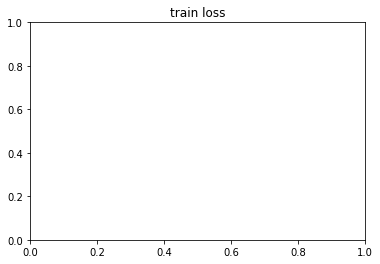

In [37]:
plt.title('train loss')
plt.plot(history['train_loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

NameError: ignored

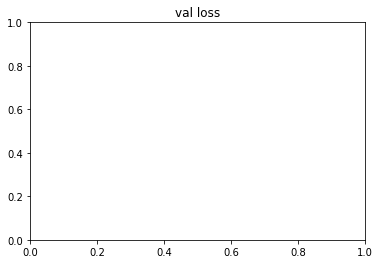

In [38]:
plt.title('val loss')
plt.plot(history['val_loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

NameError: ignored

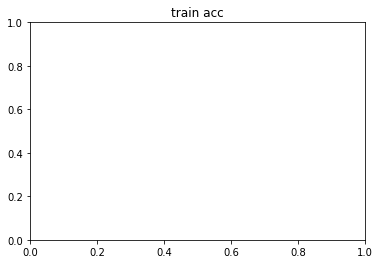

In [39]:
plt.title('train acc')
plt.plot(history['train_acc'])
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

NameError: ignored

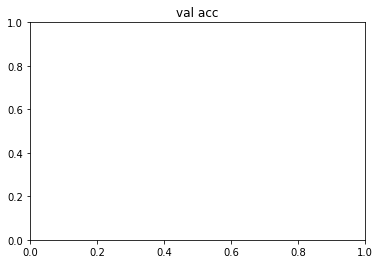

In [40]:
plt.title('val acc')
plt.plot(history['val_acc'])
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

# recall and f1 and precision

In [41]:
model.eval()
running_acc = 0
y_true = []
y_pred = []
with torch.no_grad():
    for idx, (X, y) in enumerate(tqdm(valloader)):
        X, y = X.to(device), y.to(device)
        y_hat = model(X)
        pred_idx = y_hat.max(1, keepdim=True)[1][:,0]
        y_true = y_true + y.tolist()
        y_pred = y_pred + pred_idx.tolist()


NameError: ignored

In [42]:
from sklearn.metrics import recall_score,f1_score,precision_score,multilabel_confusion_matrix

print("recall: " , recall_score(y_true, y_pred, average='macro'))
print("precision: ", precision_score(y_true, y_pred, average='micro'))
print("f1: ", f1_score(y_true, y_pred, average='macro'))
multilabel_confusion_matrix(y_true, y_pred,labels=[0,1,2,3,4,5,6,7,8,9])

recall:  nan
precision:  0.0
f1:  nan


/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


array([[[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]],

       [[0., 0.],
        [0., 0.]]])

# show data and prediction

torch.Size([3, 224, 224])


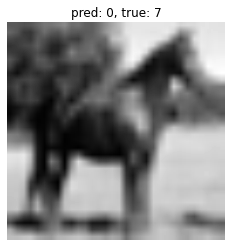

In [43]:
idx=5
images, labels = next(iter(valloader))
img, label = images[idx].to(device), labels[idx].to(device)
print(img.shape)
img = img.reshape([1,3,224,224])
with torch.no_grad():
    y_hat = model(img)
pred_idx = y_hat.max(1)[1].item()
plt.imshow(images[idx][0], cmap='gray')
plt.axis(False)
plt.title(f'pred: {pred_idx}, true: {label}')
plt.show()

# Question 4

In [44]:
from keras.datasets import cifar10
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense,Flatten
import numpy as np
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

(trainX, trainy), (testX, testy) = cifar10.load_data()
X_train, X_test, y_train, y_test = train_test_split(trainX, trainy, test_size=0.30, random_state=42)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
testX = testX.astype('float32')

X_train = X_train / 255.0
X_test = X_test / 255.0
testX = testX / 255.0

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
testy = to_categorical(testy)
def build_model(n_classes=10, IMG_HEIGHT=32, IMG_WIDTH=32, IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2),strides=(2,2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = Dropout(0.05)(c2)
    p2 = MaxPooling2D((2, 2),strides=(2,2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2),strides=(2,2))(c3)

    drop = Dropout(0.1)(p3)
    flat = Flatten()(drop)
    den1 = Dense(1024, activation = 'relu')(flat)
    out1 = Dense(512, activation ='relu')(den1)
    drop1 = Dropout(0.1)(out1)
    out = Dense(n_classes, activation ='softmax')(drop1)
    model = Model(inputs = inputs, outputs =out )

    return model

model = build_model()
#print(model.summary())

opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=5, batch_size=64)
model.save("./classify-5epoch-10class.hdf5")
_,acc = model.evaluate(testX,testy)
print("Accuracy is :",(acc * 100.0),"%")
pred = model.predict(X_test)

indexs = []
label = []
new_x_test = []
for idx,sample in enumerate(pred):
  temp = np.argmax(sample)
  if sample[temp] >=0.5:
    indexs.append(idx)
    label.append(temp)
  else:
    new_x_test.append(X_test[idx])

new_X = X_test[indexs]
new_X_train = np.concatenate((X_train,new_X))
label = to_categorical(label)
new_y_train = np.concatenate((y_train,label))
history1 = model.fit(new_X_train, new_y_train, epochs=1, batch_size=64)
pred = model.predict(new_x_test)
indexs = []
label = []
new_x_test = []
for idx,sample in enumerate(pred):
  temp = np.argmax(sample)
  if sample[temp] >=0.5:
    indexs.append(idx)
    label.append(temp)
  else:
    new_x_test.append(X_test[idx])
new_X = X_test[indexs]
new_X_train = np.concatinate((new_X_train,new_X))
label = to_categorical(label)
new_y_train = np.concatinate((new_y_train,label))
history2 = model.fit(new_X_train, new_y_train, epochs=1, batch_size=64)

_,acc = model.evaluate(testX,testy)
print("Accuracy is :",(acc * 100.0),"%")

class_auc = np.zeros((1,10))
class_len = np.zeros((1,10))

for x_t,y_t in zip(testX, testy):
    x_t_d = np.expand_dims(x_t,0)
    pred = model.predict(x_t_d)
    y_pred_arg = np.argmax(pred)
    y_gt_arg = np.argmax(y_t)

    if y_gt_arg==y_pred_arg:
        class_auc[0,y_gt_arg] +=1
        class_len[0,y_gt_arg] +=1
    
    else:
        class_len[0,y_gt_arg] +=1

print('accuracy per class...')
print(class_auc/class_len)

170498071/170498071 [==============================] - 4s 0us/step
Epoch 1/5
547/547 [==============================] - 14s 19ms/step - loss: 1.4961 - accuracy: 0.4599
Epoch 2/5
547/547 [==============================] - 10s 19ms/step - loss: 1.0856 - accuracy: 0.6085
Epoch 3/5
547/547 [==============================] - 10s 18ms/step - loss: 0.8846 - accuracy: 0.6867
Epoch 4/5
547/547 [==============================] - 10s 18ms/step - loss: 0.7522 - accuracy: 0.7342
Epoch 5/5
313/313 [==============================] - 2s 5ms/step - loss: 0.9018 - accuracy: 0.6876
Accuracy is : 68.76000165939331 %
739/739 [==============================] - 14s 19ms/step - loss: 0.5386 - accuracy: 0.8090


ValueError: ignored

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense,Flatten
import numpy as np
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def build_model(n_classes=10, IMG_HEIGHT=32, IMG_WIDTH=32, IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2),strides=(2,2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = Dropout(0.05)(c2)
    p2 = MaxPooling2D((2, 2),strides=(2,2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2),strides=(2,2))(c3)

    drop = Dropout(0.1)(p3)
    flat = Flatten()(drop)
    den1 = Dense(1024, activation = 'relu')(flat)
    out1 = Dense(512, activation ='relu')(den1)
    drop1 = Dropout(0.1)(out1)
    out = Dense(n_classes, activation ='softmax')(drop1)
    model = Model(inputs = inputs, outputs =out )

    return model


def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_data():
    data_x = []
    data_y = []
    ships = []
    files = ['data_batch_'+str(i) for i in range(1,6,1)]
    for f_name in files:
        data_dic = unpickle(f_name)
        X,Y,ship = convertMat2Img(data_dic)
        data_x.extend(X)
        data_y.extend(Y)
        ships.extend(ship)
    
    return np.array(data_x), np.array(data_y), np.array(ships)

def convertMat2Img(data):
    x = data[b'data']
    y = data[b'labels']
    img_dataset = []
    img_label = []
    ship_class = []
    
    for i in range(len(x)):
        xx = x[i]
        r = np.expand_dims(np.reshape(xx[:1024],(32,32)),axis=2)
        g = np.expand_dims(np.reshape(xx[1024:2048],(32,32)),axis=2)
        b = np.expand_dims(np.reshape(xx[2048:],(32,32)),axis=2)
        rgb = np.concatenate((r,g,b),axis=2)
        if y[i]==8:
            ship_class.append(rgb)
        else:
            img_dataset.append(rgb)
            img_label.append(y[i])
    
    #return np.array(img_dataset), np.array(img_label), np.array(ship_class)
    return img_dataset, img_label, ship_class

def Plot_ACC(history):
    acc = history.history['accuracy']
    epochs = range(1,len(acc)+1)

    plt.plot(epochs,acc,'y',label='Traning Accuracy')
    plt.title('Traning Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


X,Y,ship = load_data()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

train_norm = X_train.astype('float32')
test_norm = X_test.astype('float32')

train_norm = train_norm / 255.0
test_norm = test_norm / 255.0


trainY = to_categorical(y_train)
testY = to_categorical(y_test)

model = build_model()
#print(model.summary())

opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(train_norm, trainY, epochs=20, batch_size=64)
Plot_ACC(history)

weight_path = 'C:/VSC_workapace/sisi/HW4/'
model.save(weight_path+"classify-10class.hdf5")
print('model saved....')

class_auc = np.zeros((1,10))
class_len = np.zeros((1,10))

for x_t,y_t in zip(test_norm, testY):
    x_t_d = np.expand_dims(x_t,0)
    pred = model.predict(x_t_d)
    y_pred_arg = np.argmax(pred)
    y_gt_arg = np.argmax(y_t)

    if y_gt_arg==y_pred_arg:
        class_auc[0,y_gt_arg] +=1
        class_len[0,y_gt_arg] +=1
    
    else:
        class_len[0,y_gt_arg] +=1

print('accuracy per class...')
print(class_auc/class_len)


FileNotFoundError: [Errno 2] No such file or directory: 'data_batch_1'

# Question 5

In [46]:
from re import X
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense,Flatten
import numpy as np
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def build_model(n_classes=10, IMG_HEIGHT=32, IMG_WIDTH=32, IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2),strides=(2,2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = Dropout(0.05)(c2)
    p2 = MaxPooling2D((2, 2),strides=(2,2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2),strides=(2,2))(c3)

    drop = Dropout(0.1)(p3)
    flat = Flatten()(drop)
    den1 = Dense(1024, activation = 'relu')(flat)
    out1 = Dense(512, activation ='relu')(den1)
    drop1 = Dropout(0.1)(out1)
    out = Dense(n_classes, activation ='softmax')(drop1)
    model = Model(inputs = inputs, outputs =out )

    return model

path = 'C:/VSC_workapace/sisi/HW4/cc/'
def unpickle(file):
    import pickle
    with open(path+file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_data():
    data_x = []
    data_y = []
    ships = []
    files = ['data_batch_'+str(i) for i in range(1,6,1)]
    for f_name in files:
        data_dic = unpickle(f_name)
        X,Y,ship = convertMat2Img(data_dic)
        data_x.extend(X)
        data_y.extend(Y)
        ships.extend(ship)
    
    return np.array(data_x), np.array(data_y), np.array(ships)

def convertMat2Img(data):
    x = data[b'data']
    y = data[b'labels']
    img_dataset = []
    img_label = []
    ship_class = []
    
    for i in range(len(x)):
        xx = x[i]
        r = np.expand_dims(np.reshape(xx[:1024],(32,32)),axis=2)
        g = np.expand_dims(np.reshape(xx[1024:2048],(32,32)),axis=2)
        b = np.expand_dims(np.reshape(xx[2048:],(32,32)),axis=2)
        rgb = np.concatenate((r,g,b),axis=2)
        if y[i]==8:
            ship_class.append(rgb)
        else:
            img_dataset.append(rgb)
            img_label.append(y[i])
    
    #return np.array(img_dataset), np.array(img_label), np.array(ship_class)
    return img_dataset, img_label, ship_class

def Plot_ACC(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1,len(acc)+1)

    plt.plot(epochs,acc,'y',label='Traning Accuracy')
    plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
    plt.title('Traning and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

X = []
X_w,Y,ship = load_data()
X.extend(X_w)
X.extend(ship[0:200])
X = np.array(X)
Y = np.concatenate((Y,np.repeat([8],200)),0)
print(X.shape)
print(Y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

train_norm = X_train.astype('float32')
test_norm = X_test.astype('float32')

train_norm = train_norm / 255.0
test_norm = test_norm / 255.0


trainY = to_categorical(y_train)
testY = to_categorical(y_test)

model = build_model()
#print(model.summary())

opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


history = model.fit(train_norm, trainY, epochs=20, batch_size=64, validation_data=(test_norm, testY), verbose=1)
Plot_ACC(history)

weight_path = 'C:/VSC_workapace/sisi/HW4/'
model.save(weight_path+"classify-10class.hdf5")
print('model saved....')

class_auc = np.zeros((1,10))
class_len = np.zeros((1,10))

for x_t,y_t in zip(test_norm, testY):
    x_t_d = np.expand_dims(x_t,0)
    pred = model.predict(x_t_d)
    y_pred_arg = np.argmax(pred)
    y_gt_arg = np.argmax(y_t)

    if y_gt_arg==y_pred_arg:
        class_auc[0,y_gt_arg] +=1
        class_len[0,y_gt_arg] +=1
    
    else:
        class_len[0,y_gt_arg] +=1

print('accuracy per class...')
print(class_auc/class_len)




FileNotFoundError: ignored